### Import libraries

First of all, we import all the required modules and classes from the specific libraries here to centralize the imports at a single place.

In [1]:
import numpy as np
import torch
import torch.optim as optim
from torch import FloatTensor, LongTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from model_definition import CurrencyClassifier

### Define Constants

Here, we define all the required constants to centralize the constant values at a single place.

In [33]:
SAVED_DATASETS_DIR = '../../saved/processed/'
SAVED_MODELS_DIR = '../../saved/models/'
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.3

### Select Device

Here, we select the device to be GPU(cuda) if it is available, and use CPU for fallback.

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load Preprocessed Datasets

Now, we load the saved preprocessed datasets for usage, and check the shapes for each

In [35]:
X_train = np.load(SAVED_DATASETS_DIR + 'X_train.npy')
X_val = np.load(SAVED_DATASETS_DIR + 'X_val.npy')
y_train = np.load(SAVED_DATASETS_DIR + 'y_train.npy')
y_val = np.load(SAVED_DATASETS_DIR + 'y_val.npy')

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)

X_train shape:  (17784, 256)
X_val shape:  (1976, 256)
y_train shape:  (17784,)
y_val shape:  (1976,)


### Create TensorDataset and DataLoader

Now, we use the loaded datasets, convert them into tensors, create the tensor datasets, create the data loaders, and take the input and output dimensions of the data in order to use them for training the model.

In [36]:
X_train_tensor = FloatTensor(X_train)
X_val_tensor = FloatTensor(X_val)
y_train_tensor = LongTensor(y_train)
y_val_tensor = LongTensor(y_val)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

input_dim = X_train_tensor.shape[1]
output_dim = len(y_train_tensor.unique())
print(f"Input = {input_dim}, Output = {output_dim}")

Input = 256, Output = 17


### Initialize the Model, Loss Function, and Optimizer

Here, we initialize the neural network model, CrossEntropyLoss as the loss function, and Adam as the optimizer.

In [37]:
model = CurrencyClassifier(input_dim, output_dim, DROPOUT_RATE).to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training and Validation

Now, we train the model in epoches using the train data loader, and keep track of the loss, accuracy, and the best state of the model. And, we also validate the evaluation of the model using the validation data loader in similar manner.

In [38]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_running_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

Epoch 1/20 | Train Loss: 0.6136 | Train Acc: 0.8211 | Val Loss: 0.2331 | Val Acc: 0.9332
Epoch 2/20 | Train Loss: 0.2958 | Train Acc: 0.9173 | Val Loss: 0.1867 | Val Acc: 0.9448
Epoch 3/20 | Train Loss: 0.2413 | Train Acc: 0.9326 | Val Loss: 0.1560 | Val Acc: 0.9494
Epoch 4/20 | Train Loss: 0.2108 | Train Acc: 0.9403 | Val Loss: 0.1622 | Val Acc: 0.9539
Epoch 5/20 | Train Loss: 0.1835 | Train Acc: 0.9468 | Val Loss: 0.1434 | Val Acc: 0.9580
Epoch 6/20 | Train Loss: 0.1709 | Train Acc: 0.9508 | Val Loss: 0.1368 | Val Acc: 0.9575
Epoch 7/20 | Train Loss: 0.1576 | Train Acc: 0.9553 | Val Loss: 0.1487 | Val Acc: 0.9575
Epoch 8/20 | Train Loss: 0.1461 | Train Acc: 0.9587 | Val Loss: 0.1499 | Val Acc: 0.9560
Epoch 9/20 | Train Loss: 0.1425 | Train Acc: 0.9578 | Val Loss: 0.1531 | Val Acc: 0.9580
Epoch 10/20 | Train Loss: 0.1291 | Train Acc: 0.9633 | Val Loss: 0.1346 | Val Acc: 0.9605
Epoch 11/20 | Train Loss: 0.1180 | Train Acc: 0.9628 | Val Loss: 0.1456 | Val Acc: 0.9610
Epoch 12/20 | Train

### Loss and Accuracy Visualization

Here, we visualize the loss and accuracy of the training and validation.

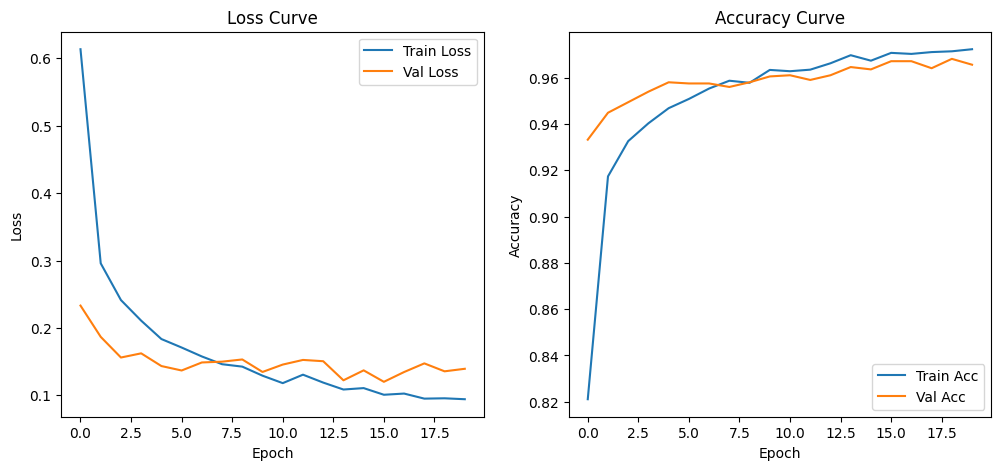

In [39]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

### Save the Best Model

At last, we save the best model in a `.pth` file for using it using re-training in the future.

In [40]:
torch.save(best_model_state, SAVED_MODELS_DIR + 'currency_classifier.pth')